In [117]:
from __future__ import print_function
import os.path
import pickle
import pandas as pd
import sys
sys.path.insert(0, '../../')
import numpy as np
import itertools

#import Datanalytics as da 
from JKBio import terra
from JKBio.utils import helper as h
from JKBio.google import gcp
from JKBio import rna
from JKBio.utils import plot

from taigapy import TaigaClient
import dalmatian as dm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from JKBio.rna import pyDESeq2
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import gseapy

from sklearn.preprocessing import scale
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from bokeh.plotting import *
from bokeh.models import HoverTool
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [ ]:
#Experiment outline: MONOMAC1 cell line, simultaneous RNP knockout of MEF2D and MEF2C  followed by RNAseq at 48 and 72 hours. 
project = "MONOMAC_synMEF2CD"
version = "v1"

## getting data

In [7]:
! gsutil mv gs://transfer-amlproject/*MP8456*/*.fastq.gz gs://transfer-amlproject/$project/

Copying gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_A_MP8456_S46_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Removing gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_A_MP8456_S46_R1_001.fastq.gz...
Copying gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_A_MP8456_S46_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Removing gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_A_MP8456_S46_R2_001.fastq.gz...
Copying gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_B_MP8456_S47_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Removing gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_B_MP8456_S47_R1_001.fastq.gz...
Copying gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_B_MP8456_S47_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Removing gs://transfer-amlproject/201120_MP8456_fastq/20201120_48h_2C_2D_B_MP8456_S47_R2_001.fastq.gz...

==>

In [9]:
! gsutil -m cp gs://transfer-amlproject/$project/* gs://amlproject/RNA/$project/

Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_A_MP8456_S46_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_A_MP8456_S46_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_B_MP8456_S47_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_B_MP8456_S47_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_C_MP8456_S48_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_C_MP8456_S48_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/MONOMAC_synMEF2CD/20201120_48h_2C_2D_D_MP8456_S49_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copyin

### Rename

In [8]:
rename={"20201120_48h_2C_2D_A_MP8456_S46": "mr327-MONOMAC1-48h_MEF2C_MEF2D-r1",
"20201120_48h_2C_2D_B_MP8456_S47": "mr328-MONOMAC1-48h_MEF2C_MEF2D-r2",
"20201120_48h_2C_2D_C_MP8456_S48": "mr329-MONOMAC1-48h_MEF2C_MEF2D-r3",
"20201120_48h_2C_2D_D_MP8456_S49": "mr330-MONOMAC1-48h_MEF2C_MEF2D-r4",
"20201120_48h_AAVS1_A_MP8456_S42": "mr331-MONOMAC1-48h_AAVS1-r1",
"20201120_48h_AAVS1_B_MP8456_S43": "mr332-MONOMAC1-48h_AAVS1-r2",
"20201120_48h_AAVS1_C_MP8456_S44": "mr333-MONOMAC1-48h_AAVS1-r3",
"20201120_48h_AAVS1_D_MP8456_S45": "mr334-MONOMAC1-48h_AAVS1-r4",
"20201120_72h_2C_2D_A_MP8456_S54": "mr335-MONOMAC1-72h_MEF2C_MEF2D-r1",
"20201120_72h_2C_2D_B_MP8456_S55": "mr336-MONOMAC1-72h_MEF2C_MEF2D-r2",
"20201120_72h_2C_2D_C_MP8456_S56": "mr337-MONOMAC1-72h_MEF2C_MEF2D-r3",
"20201120_72h_2C_2D_D_MP8456_S57": "mr338-MONOMAC1-72h_MEF2C_MEF2D-r4",
"20201120_72h_AAVS1_A_MP8456_S50": "mr339-MONOMAC1-72h_AAVS1-r1",
"20201120_72h_AAVS1_B_MP8456_S51": "mr340-MONOMAC1-72h_AAVS1-r2",
"20201120_72h_AAVS1_C_MP8456_S52": "mr341-MONOMAC1-72h_AAVS1-r3",
"20201120_72h_AAVS1_D_MP8456_S53": "mr342-MONOMAC1-72h_AAVS1-r4",}

In [12]:
gcp.patternRN(rename,'gs://amlproject/RNA/'+project+'/',['.*'], dryrun=False)

found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename
found 2 files to rename


## Running on Terra

In [13]:
terra.uploadFromFolder('amlproject','RNA/'+project+"/",
                       'broad-firecloud-ccle/hg38_RNAseq',samplesetname=project,
                      fformat="fastqR1R2", sep='_R1|_R2', test=False)

please be sure you gave access to your terra email account access to this bucket


/home/jeremie/.local/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/jeremie/.local/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accoun

['RNA/MONOMAC_synMEF2CD/mr327-MONOMAC1-48h_MEF2C_MEF2D-r1_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr327-MONOMAC1-48h_MEF2C_MEF2D-r1_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr328-MONOMAC1-48h_MEF2C_MEF2D-r2_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr328-MONOMAC1-48h_MEF2C_MEF2D-r2_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr329-MONOMAC1-48h_MEF2C_MEF2D-r3_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr329-MONOMAC1-48h_MEF2C_MEF2D-r3_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr330-MONOMAC1-48h_MEF2C_MEF2D-r4_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr330-MONOMAC1-48h_MEF2C_MEF2D-r4_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr331-MONOMAC1-48h_AAVS1-r1_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr331-MONOMAC1-48h_AAVS1-r1_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr332-MONOMAC1-48h_AAVS1-r2_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr332-MONOMAC1-48h_AAVS1-r2_R2_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr333-MONOMAC1-48h_AAVS1-r3_R1_001.fastq.gz', 'RNA/MONOMAC_synMEF2CD/mr333-MONOMAC1-48h_AAVS1-r3_R2_

/home/jeremie/.local/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully imported 16 participants.


/home/jeremie/.local/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/jeremie/.local/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accoun

Successfully imported 16 samples.
Successfully imported 1 sample sets:
  * MONOMAC_synMEF2CD (16 samples)


,fastq1,fastq2,Source,participant
sample_id,,,,
mr327-MONOMAC1-48h_MEF2C_MEF2D-r1,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr327-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr327-MO...,U,mr327-MONOMAC1-48h_MEF2C_MEF2D-r1
mr328-MONOMAC1-48h_MEF2C_MEF2D-r2,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr328-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr328-MO...,U,mr328-MONOMAC1-48h_MEF2C_MEF2D-r2
mr329-MONOMAC1-48h_MEF2C_MEF2D-r3,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr329-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr329-MO...,U,mr329-MONOMAC1-48h_MEF2C_MEF2D-r3
mr330-MONOMAC1-48h_MEF2C_MEF2D-r4,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr330-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr330-MO...,U,mr330-MONOMAC1-48h_MEF2C_MEF2D-r4
mr331-MONOMAC1-48h_AAVS1-r1,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr331-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr331-MO...,U,mr331-MONOMAC1-48h_AAVS1-r1
mr332-MONOMAC1-48h_AAVS1-r2,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr332-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr332-MO...,U,mr332-MONOMAC1-48h_AAVS1-r2
mr333-MONOMAC1-48h_AAVS1-r3,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr333-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr333-MO...,U,mr333-MONOMAC1-48h_AAVS1-r3
mr334-MONOMAC1-48h_AAVS1-r4,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr334-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr334-MO...,U,mr334-MONOMAC1-48h_AAVS1-r4
mr335-MONOMAC1-72h_MEF2C_MEF2D-r1,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr335-MO...,gs://amlproject/RNA/MONOMAC_synMEF2CD/mr335-MO...,U,mr335-MONOMAC1-72h_MEF2C_MEF2D-r1


In [14]:
wm = dm.WorkspaceManager('broad-firecloud-ccle/hg38_RNAseq')

In [17]:
submission_id = wm.create_submission("star_v1-0_BETA_cfg", project, 'sample_set',expression='this.samples')
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

Successfully created submission 626ba929-9477-4c58-92d5-b766ed778a28.
1.0 of jobs Succeeded in submission 0.sion 0. 159 mn elapsed..


[]

In [18]:
submission_id = wm.create_submission("rsem_v1-0_BETA_cfg", project, 'sample_set', expression = 'this.samples')
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

Successfully created submission 97343f81-b722-4ac2-8c35-8b8ded3171ce.
1.0 of jobs Succeeded in submission 0.sion 0. 201 mn elapsed..


[]

In [19]:
submission_id = wm.create_submission("rsem_aggregate_results_v1-0_BETA_cfg", project)
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

Successfully created submission c7dfe235-dd50-4b72-b5c5-afeb53eeedb2.
1.0 of jobs Succeeded in submission 0.sion 0. 8 mn elapsed.


[]

In [20]:
results = wm.get_sample_sets().loc[project]
rsem_genes_expected_count = results['rsem_genes_expected_count']

## Loading

In [21]:
mkdir ../data/$project

In [22]:
! gsutil cp $rsem_genes_expected_count ../data/$project/

Copying gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcbabe2da/c7dfe235-dd50-4b72-b5c5-afeb53eeedb2/rsem_aggregate_results_workflow/b80a41a7-9f7d-4384-adb2-ef160711fd7a/call-rsem_aggregate_results/MONOMAC_synMEF2CD.rsem_genes_expected_count.txt.gz...
/ [1 files][  1.7 MiB/  1.7 MiB]                                                
Operation completed over 1 objects/1.7 MiB.                                      


In [23]:
file = '../data/'+project+'/'+rsem_genes_expected_count.split('/')[-1]

In [26]:
! gunzip $file

In [29]:
rsem_genes_expected_count = pd.read_csv(file[:-3], sep='\t')

In [30]:
data = rsem_genes_expected_count.drop("transcript_id(s)", 1).set_index('gene_id')

In [35]:
data.index = rna.convertGenes(data.index)[0]

you need access to taiga for this (https://pypi.org/project/taigapy/)
20702 could not be parsed... we don't have all genes already


## post processing and filtering

filter some more

In [36]:
toremove = np.argwhere(data.values.var(1)==0)
toremove.ravel()

array([    0,    15,    24, ..., 58715, 58716, 58719])

In [37]:
data = data.drop(data.iloc[toremove.ravel()].index,0)

In [38]:
data.shape

(30010, 16)

In [79]:
ERCC = data[~data.index.str.contains('ENSG00')]

In [40]:
data = data[~data.index.str.contains('ENSG00')]

renormalize the data

In [41]:
len(ERCC)

21801

## Loading the CRC members

In [46]:
ctf=pd.read_csv('../data/CRCs.csv',header=None)[0].values.tolist()
ctf

['CEBPA',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'HEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZNF281',
 'LMO2',
 'ZMYND8',
 'GATA2',
 'MAX',
 'MYC',
 'ETV6',
 'HOXA9']

## Correlation analysis across replicates

In [47]:
a = data.columns.tolist()
a.sort()
data =data[a]

I would like to spend a bit of time looking at this matrix, we can see that it contains a lot of weird things and adding the additionals did not help decipher it to me. 

We have a set of samples IRF2BP2 r4, MYCs r4,5,6, RUNX1s r7,8,9, SPI1 R4,r7 are all very different from their replicates or the rest of the experiment but ccan be closer to some unrelated experiments.

We can not as well the difference in the AAVS1s and a strange pattern showing likely misslabeling in AAVS1 r7.

In [51]:
!mkdir ../results/$project/
!mkdir ../results/$project/plots/

mkdir: cannot create directory ‘../results/MONOMAC_synMEF2CD/’: File exists


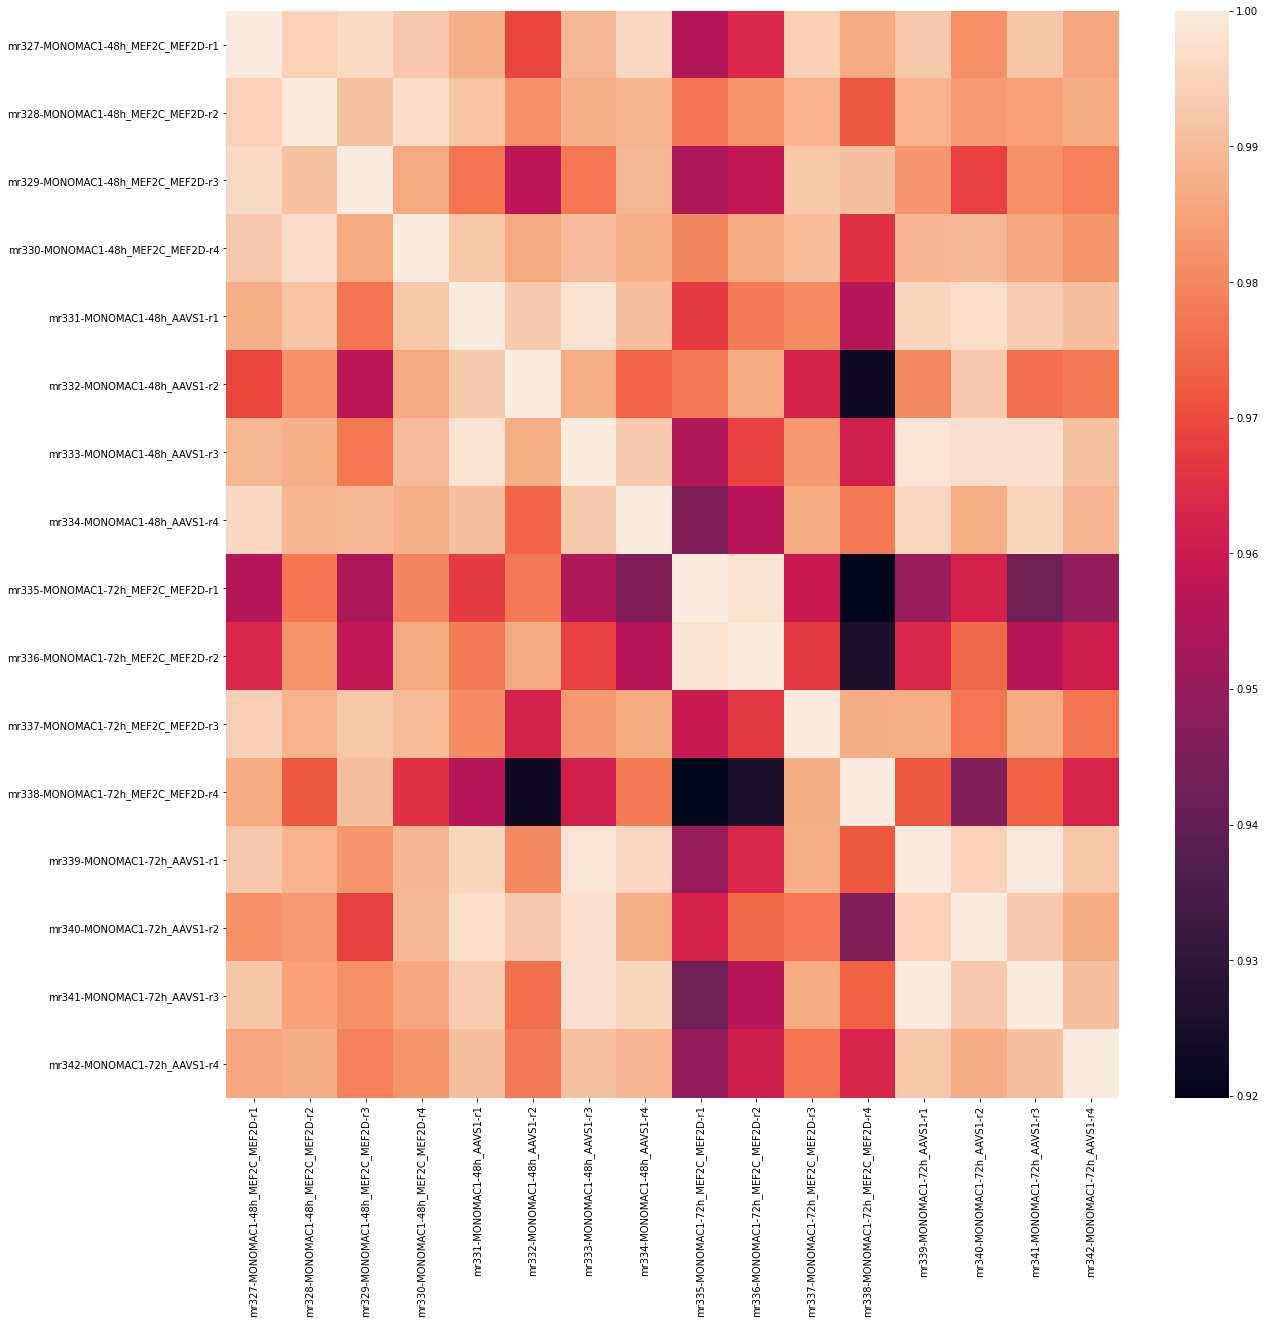

In [52]:
%matplotlib inline
ig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), 
            xticklabels=data.columns,
            yticklabels=data.columns, ax=ax)
plt.savefig('../results/'+project+'/plots/correlation_'+version+'.pdf')

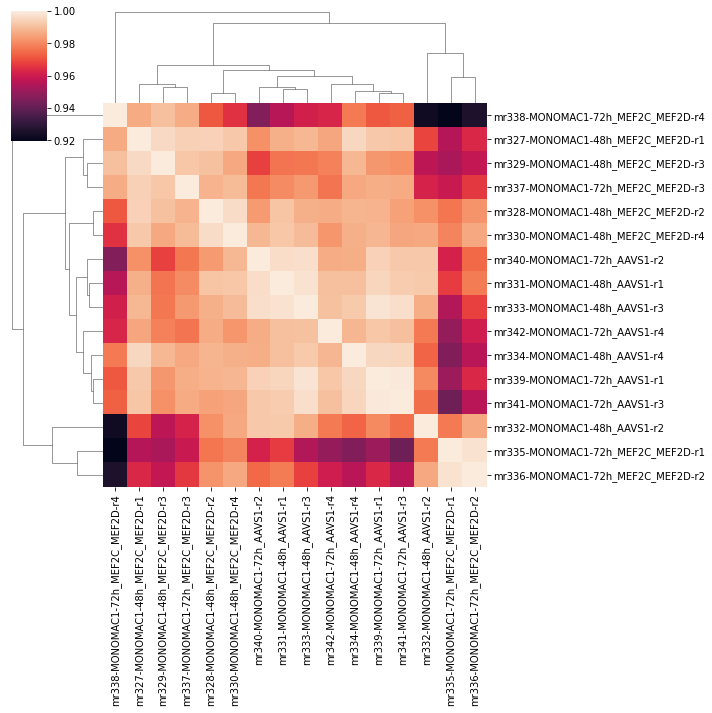

In [119]:
sns.clustermap(data.corr(), 
            xticklabels=data.columns,
            yticklabels=data.columns)

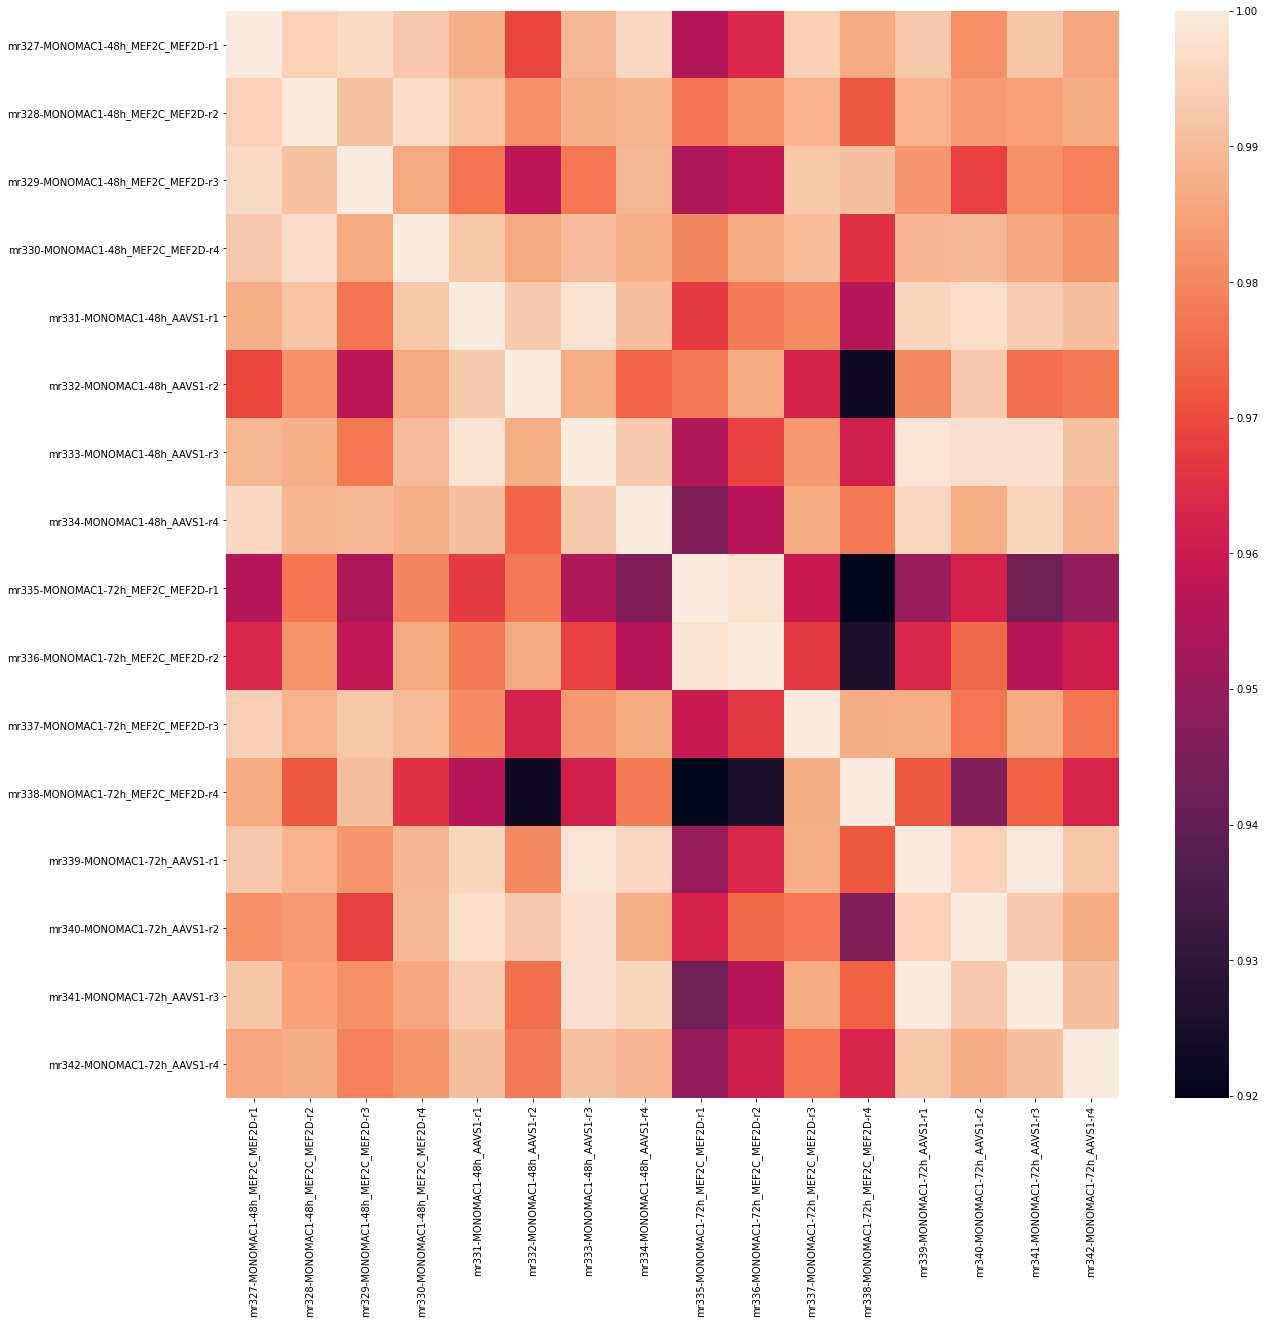

In [55]:
ig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), 
            xticklabels=data.columns,
            yticklabels=data.columns, ax=ax)
plt.savefig('../results/'+project+'/plots/correlation_'+version+'.pdf')

In [56]:
data.to_csv('../results/'+project+'/'+version+'_counts.csv')

In [58]:
version = 'v1'

In [ ]:
data = pd.read_csv('../results/'+project+'/'+version+'_counts.csv',index_col=0)

## We are looking for bias in the data and the replicates

In [59]:
col = {v:i for i, v in enumerate(set([i.split('-')[2] for i in data.columns[:-1]]))}

In [60]:
col

{'72h_MEF2C_MEF2D': 0, '48h_AAVS1': 1, '48h_MEF2C_MEF2D': 2, '72h_AAVS1': 3}

In [184]:
sdata = data.copy()

In [185]:
data = data[[i for i in data.columns if i.split('-')[0] not in  ["mr334", "mr342", "mr338", "mr329"]]]

In [186]:
red = PCA(2).fit_transform(data[data.columns[:-1]].T)
plot.scatter(red, labels=data.columns[:-1], title="PCA plot across replicates", radi=60000, colors=[col[i.split('-')[2]] for i in data.columns[:-1]], folder= "../results/"+project+"/plots/"+version+"_", showlabels=True)

Figure(id='4233', ...)

mr129-MYC-r4 seems weird

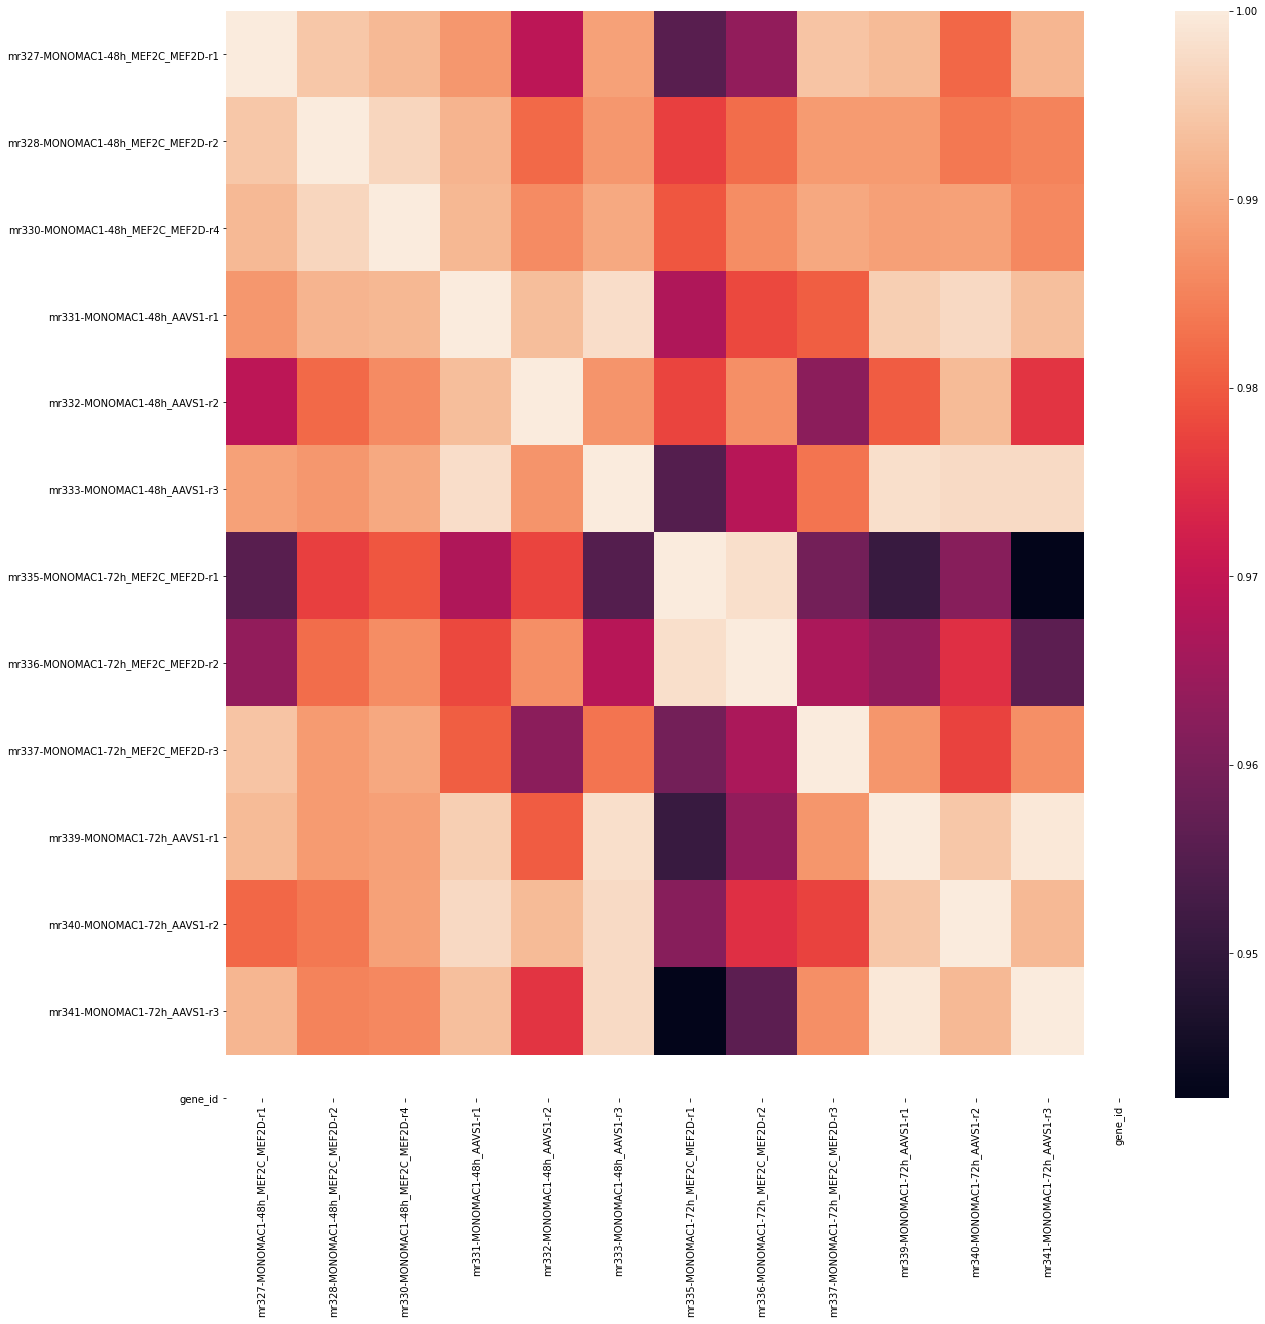

In [187]:
%matplotlib inline
ig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), 
            xticklabels=data.columns,
            yticklabels=data.columns, ax=ax)
plt.savefig('../results/'+project+'/plots/correlation_'+version+'.pdf')

## Making and running the dashboard

In [81]:
ERCC = ERCC.astype(int)

In [82]:
ERCC['Feature'] = ERCC.index

In [93]:
ERCC.columns = [i.replace('_','') for i in ERCC.columns]

In [89]:
experiments = list(set([i.split('-')[2].replace('_','') for i in ERCC.columns[:-1]]))
experiments

['72hAAVS1', '48hMEF2CMEF2D', '72hMEF2CMEF2D', '48hAAVS1']

In [99]:
ERCC

,mr327-MONOMAC1-48hMEF2CMEF2D-r1,mr328-MONOMAC1-48hMEF2CMEF2D-r2,mr329-MONOMAC1-48hMEF2CMEF2D-r3,mr330-MONOMAC1-48hMEF2CMEF2D-r4,mr331-MONOMAC1-48hAAVS1-r1,mr332-MONOMAC1-48hAAVS1-r2,mr333-MONOMAC1-48hAAVS1-r3,mr334-MONOMAC1-48hAAVS1-r4,mr335-MONOMAC1-72hMEF2CMEF2D-r1,mr336-MONOMAC1-72hMEF2CMEF2D-r2,mr337-MONOMAC1-72hMEF2CMEF2D-r3,mr338-MONOMAC1-72hMEF2CMEF2D-r4,mr339-MONOMAC1-72hAAVS1-r1,mr340-MONOMAC1-72hAAVS1-r2,mr341-MONOMAC1-72hAAVS1-r3,mr342-MONOMAC1-72hAAVS1-r4,Feature
TNMD,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,TNMD
DPM1,670,888,1321,1014,1105,1084,1332,1037,792,902,600,1664,999,960,1022,1543,DPM1
SCYL3,121,144,209,186,209,213,191,171,153,219,131,315,193,201,208,245,SCYL3
C1orf112,280,329,462,397,493,450,534,430,294,335,190,556,434,416,446,638,C1orf112
FGR,1203,1487,2106,1931,1448,1383,1704,1051,2172,2280,1983,3839,1377,1366,1323,1631,FGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERCC-00164,9,19,27,19,15,12,19,13,10,10,14,34,26,13,14,16,ERCC-00164
ERCC-00165,1132,1351,2182,1430,1587,1151,1980,1498,1035,1169,1428,4313,1574,1442,1749,2302,ERCC-00165
ERCC-00168,14,29,50,42,30,25,28,35,17,18,33,73,32,16,33,44,ERCC-00168
ERCC-00170,85,94,174,114,98,94,114,117,66,82,97,290,113,120,109,152,ERCC-00170


In [120]:
res = rna.runERCC(ERCC, ['48hMEF2CMEF2D'], featurename="Feature", issingle=False, dilution=1/100,
name="RNPv2", spikevol=1, control="48hAAVS1", fdr=0.1, totalrnamass=0.5)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
[1] "48hMEF2CMEF2D"
[1] "48hAAVS1"
   Feature X48hMEF2CMEF2D_1 X48hMEF2CMEF2D_2 X48hMEF2CMEF2D_3 X48hMEF2CMEF2D_4
1     TNMD                0                0                0                0
2     DPM1              670              888             1321             1014
3    SCYL3              121              144              209              186
4 C1orf112              280              329              462              397
5      FGR             1203             1487             2106             1931
6      CFH               16               16               48               32
  X48hAAVS1_1 X48hAAVS1_2 X48hAAVS1_3 X48hAAVS1_4
1           0           0           2           0
2        1105        1084        1332        1037
3         209         213         191         171
4         493         450         534         430
5        1448        1383        1704        1051
6          22       

R[write to console]: Error in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,  : 
  invalid 'x'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In min(log2(AandB$value)) :
R[write to console]:  no non-missing arguments to min; returning Inf




Error in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,  : 
  invalid 'x'
              Length Class      Mode     
sampleInfo    11     -none-     list     
plotInfo       9     -none-     list     
erccInfo       4     -none-     list     
Transcripts    9     data.frame list     
designMat      3     data.frame list     
sampleNames    2     -none-     character
idCols         6     data.frame list     
normERCCDat    9     data.frame list     
normFactor     8     -none-     numeric  
mnLibeFactor   1     -none-     numeric  
spikeFraction  1     -none-     numeric  
idColsAdj      6     data.frame list     
Results        2     -none-     list     
Figures        1     -none-     list     


R[write to console]: Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"




Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"
[1] 1


NameError: name 'rm' is not defined

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
[1] "72hMEF2CMEF2D"
[1] "72hAAVS1"
   Feature X72hMEF2CMEF2D_1 X72hMEF2CMEF2D_2 X72hMEF2CMEF2D_3 X72hMEF2CMEF2D_4
1     TNMD                0                0                0                0
2     DPM1              792              902              600             1664
3    SCYL3              153              219              131              315
4 C1orf112              294              335              190              556
5      FGR             2172             2280             1983             3839
6      CFH               21               17               19               42
  X72hAAVS1_1 X72hAAVS1_2 X72hAAVS1_3 X72hAAVS1_4
1           0           0           0           0
2         999         960        1022        1543
3         193         201         208         245
4         434         416         446         638
5        1377        1366        1323        1631
6          15       

R[write to console]: Error in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,  : 
  invalid 'x'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In min(log2(AandB$value)) :
R[write to console]:  no non-missing arguments to min; returning Inf




Error in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,  : 
  invalid 'x'
              Length Class      Mode     
sampleInfo    11     -none-     list     
plotInfo       9     -none-     list     
erccInfo       4     -none-     list     
Transcripts    9     data.frame list     
designMat      3     data.frame list     
sampleNames    2     -none-     character
idCols         6     data.frame list     
normERCCDat    9     data.frame list     
normFactor     8     -none-     numeric  
mnLibeFactor   1     -none-     numeric  
spikeFraction  1     -none-     numeric  
idColsAdj      6     data.frame list     
Results        2     -none-     list     
Figures        1     -none-     list     


R[write to console]: Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"




Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"


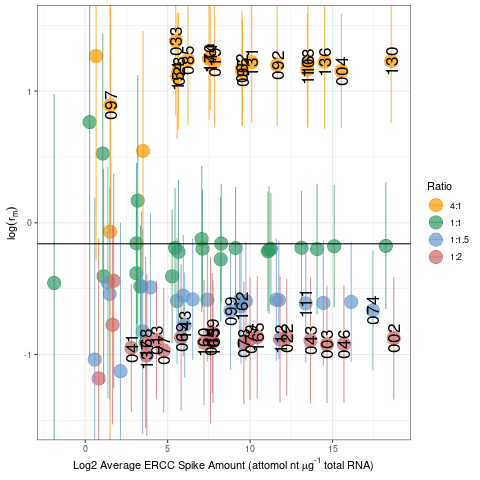

R[write to console]: Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"




Error in gList(list(wrapvp = list(x = 0.5, y = 0.5, width = 1, height = 1,  : 
  only 'grobs' allowed in "gList"
[1] 1


NameError: name 'rm' is not defined

In [101]:
a = rna.runERCC(ERCC, ['72hMEF2CMEF2D'], featurename="Feature", issingle=False, dilution=1/100,
name="RNPv2", spikevol=1, control="72hAAVS1", fdr=0.1, totalrnamass=0.5)
res.update(a)

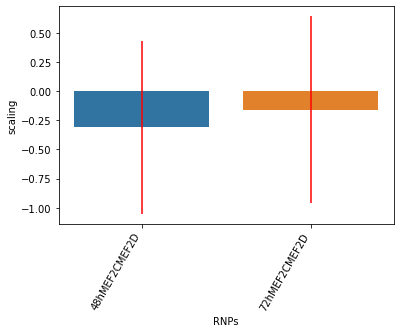

In [136]:
df= pd.DataFrame(data=res.values(),index=res.keys(), columns=['scaling','var'])
df['RNPs']=df.index
sns.barplot("RNPs","scaling",data=df,ci=None,)
plt.errorbar(x=range(0,len(df)),y=df['scaling'],
            yerr=df['var'], fmt='none', c= 'r')
plt.xticks(rotation=60,ha='right')
plt.savefig('../results/'+project+"/plots/"+version+"_scaling_fact_with_conf.pdf")

In [137]:
scaling = res
scaling

{'48hMEF2CMEF2D': (-0.309700394158224, 0.743171102607337),
 '72hMEF2CMEF2D': (-0.15950996757923, 0.801485838199572)}

In [138]:
for i, v in scaling.items():
    if abs(v[0]) > 2*v[1]:
        print(i, v[0]) 

In [ ]:
version="v1" #scaling_2, additionals, v4

In [140]:
ls ../results/$project/*_scaling.json

../results/MONOMAC_synMEF2CD/v1_scaling.json


In [139]:
h.dictToFile(scaling,"../results/"+project+"/"+version+"_scaling.json")

In [ ]:
scaling = h.fileToDict("../results/"+project+"/"+version+"_scaling.json")

## Differential expression analysis

In [141]:
data['gene_id'] = data.index

In [142]:
housekeeping = ["C1orf43", "CHMP2A", "EMC7", "GPI", "PSMB2", "PSMB4", "RAB7A", "REEP5", "SNRPD3", "VCP", "VPS29"]
# from https://www.cell.com/trends/genetics/pdf/S0168-9525(13)00089-9.pdf

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4760967/ FOR CANCER CELL LINES
housekeeping2 = ['18S rRNA',
'ACTB',
'B2M',
'G6PD',
'GAPDH',
'GUSB',
'HMBS',
'HPRT1',
'PGK1',
'PPIA',
'RPL13a',
'SDHA',
'TBP',
'TUBB',
'YWHAZ']

In [143]:
results = {}

In [144]:
experiments = list(set([i.split('-')[2] for i in data.columns[:-1]]))
experiments

['72h_MEF2C_MEF2D', '48h_AAVS1', '48h_MEF2C_MEF2D', '72h_AAVS1']

In [145]:
scaling

{'48hMEF2CMEF2D': (-0.309700394158224, 0.743171102607337),
 '72hMEF2CMEF2D': (-0.15950996757923, 0.801485838199572)}

In [146]:
for k in list(scaling.keys()):
    scaling["RNP_"+k] = scaling.pop(k)

In [151]:
results = rna.DESeqSamples(data, ['72h_MEF2C_MEF2D','48h_MEF2C_MEF2D'], controlcontain=['72h_AAVS1', '48h_AAVS1'], scaling=housekeeping2, keep=True, results={})

72h_MEF2C_MEF2D
3.3.2
scaling using a gene set


R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



____________________________________________
48h_MEF2C_MEF2D
3.3.2
scaling using a gene set


R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



____________________________________________


### volcano plot with CRC members highlighted

In [111]:
experiments

['72h_MEF2C_MEF2D', '48h_AAVS1', '48h_MEF2C_MEF2D', '72h_AAVS1']

In [178]:
results['48h_MEF2C_MEF2D'].loc['MYC']

baseMean             4501.74
log2FoldChange     -0.312415
lfcSE               0.110274
stat                -2.83309
pvalue            0.00461004
padj               0.0339424
gene_id                  MYC
Name: MYC, dtype: object

In [152]:
for val in ['72h_MEF2C_MEF2D', '48h_MEF2C_MEF2D']:
    plot.volcano(results[val],tohighlight=ctf,title=val, maxvalue= 60, searchbox=True, showlabels=True,folder="../results/"+project+"/plots/"+version+'_')

In [154]:
!mkdir ../results/$project/deseq_$version
for k, val in results.items(): 
    scale = str("geneset2")
    #scale = str(scaling[k][0] if abs(scaling[k][0]) > 1*scaling[k][1] else 0)
    val.to_csv('../results/'+project+'/deseq_'+version+'/'+ k + '_scalingof' + scale + ".csv")

mkdir: cannot create directory ‘../results/MONOMAC_synMEF2CD/deseq_v1’: File exists


In [ ]:
results.keys()

In [116]:
results.keys()

dict_keys(['72h_MEF2C_MEF2D', '48h_MEF2C_MEF2D'])

In [ ]:
#results = {}
des = ! ls ../results/$project/deseq_$version/*.csv
for val in des:
    results["RNP_"+val.split('RNP_')[-1].split('.')[0].split('_scalingof')[0]] = pd.read_csv(val,index_col=0)

In [160]:
res = {}

In [155]:
experiments

['72h_MEF2C_MEF2D', '48h_AAVS1', '48h_MEF2C_MEF2D', '72h_AAVS1']

In [158]:
scaling

{'RNP_48hMEF2CMEF2D': (-0.309700394158224, 0.743171102607337),
 'RNP_72hMEF2CMEF2D': (-0.15950996757923, 0.801485838199572)}

In [164]:
totest = data[[v for v in data.columns[:-1] if "48h_MEF2C_MEF2D" in v or '48h_AAVS1' in v]]
cls = ['Condition' if "48h_MEF2C_MEF2D" in v else 'DMSO' for v in totest.columns]
#if abs(scaling[val.split('_')[1]][0]) > 3*scaling[val.split('_')[1]][1]:
    #print("rescaling this one")
    #cols = [i for i in totest.columns if val+'-' in i]
    #totest[cols] = totest[cols]*(2**scaling[val.split('_')[1]][0])
res["48h_MEF2C_MEF2D"] = gseapy.gsea(data=totest, gene_sets='WikiPathways_2013', 
            cls= cls, no_plot=False, processes=8)
res["48h_MEF2C_MEF2D"].res2d['Term'] = [i for i in res["48h_MEF2C_MEF2D"].res2d.index]
sns.barplot(data=res["48h_MEF2C_MEF2D"].res2d.iloc[:25], x="es", y="Term",
            hue_order="geneset_size").set_title(val)

Text(0.5, 1.0, '72h_AAVS1')

In [165]:
totest = data[[v for v in data.columns[:-1] if "72h_MEF2C_MEF2D" in v or '72h_AAVS1' in v]]
cls = ['Condition' if "72h_MEF2C_MEF2D" in v else 'DMSO' for v in totest.columns]
#if abs(scaling[val.split('_')[1]][0]) > 3*scaling[val.split('_')[1]][1]:
    #print("rescaling this one")
    #cols = [i for i in totest.columns if val+'-' in i]
    #totest[cols] = totest[cols]*(2**scaling[val.split('_')[1]][0])
res["72h_MEF2C_MEF2D"] = gseapy.gsea(data=totest, gene_sets='WikiPathways_2013', 
            cls= cls, no_plot=False, processes=8)
res["72h_MEF2C_MEF2D"].res2d['Term'] = [i for i in res["72h_MEF2C_MEF2D"].res2d.index]
sns.barplot(data=res["72h_MEF2C_MEF2D"].res2d.iloc[:25], x="es", y="Term",
            hue_order="geneset_size").set_title(val)

Text(0.5, 1.0, '72h_AAVS1')

In [175]:
with open('../data/'+project+'/'+version+'_wikipathway', 'wb') as f:
    pickle.dump(res,f)

In [173]:
with open('../data/'+project+'/'+version+'_wikipathway','rb') as f:
    res = pickle.load(f)

### Analysis on the wiki pathways geneset

In [172]:
res

,"Retinol metabolism (BiGCaT, NuGO)",EPO Receptor Signaling,Selenium metabolism-Selenoproteins,Regulation of Actin Cytoskeleton,Senescence and Autophagy,Glycogen Metabolism,Complement and Coagulation Cascades KEGG,mRNA processing,Oxidative phosphorylation,Senescence and Autophagy,...,"Retinol metabolism (BiGCaT, NuGO)",TGF-beta Receptor Signaling Pathway,Statin Pathway PharmGKB,G1 to S cell cycle control,G Protein Signaling Pathways,Endochondral Ossification,Peptide GPCRs,MAPK signaling pathway,EGFR1 Signaling Pathway,Senescence and Autophagy
72h_MEF2C_MEF2D,0.369090,0.462958,-0.242670,0.251568,0.514852,-0.266838,0.793589,-0.502639,-0.406634,0.514852,...,0.369090,0.220005,0.490717,0.210126,-0.278570,0.598274,0.485068,0.330785,-0.146194,0.514852
48h_AAVS1,-0.421677,-0.382350,0.540026,0.224756,0.293079,-0.282053,0.527548,-0.208968,-0.344178,0.293079,...,-0.421677,-0.202131,0.643610,0.153956,-0.304111,0.478568,0.393554,0.186341,0.183029,0.293079
48h_MEF2C_MEF2D,0.361865,0.261335,-0.415694,-0.106095,0.322645,-0.224609,0.426877,-0.375845,-0.401471,0.322645,...,0.361865,-0.123913,0.320637,-0.170987,-0.243110,0.407892,0.583770,0.162772,-0.157124,0.322645


In [171]:
a = set()
for k, val in res.items():
    a.update(set(val.res2d.index))
a = {i:[0]*len(res) for i in a}
for n,(k, val) in enumerate(res.items()):
    for i,v in val.res2d.iterrows():
        a[i][n] = v.es
res = pd.DataFrame(a, index=res.keys())
res.columns = [i[3:].split('WP')[0] for i in res.columns]

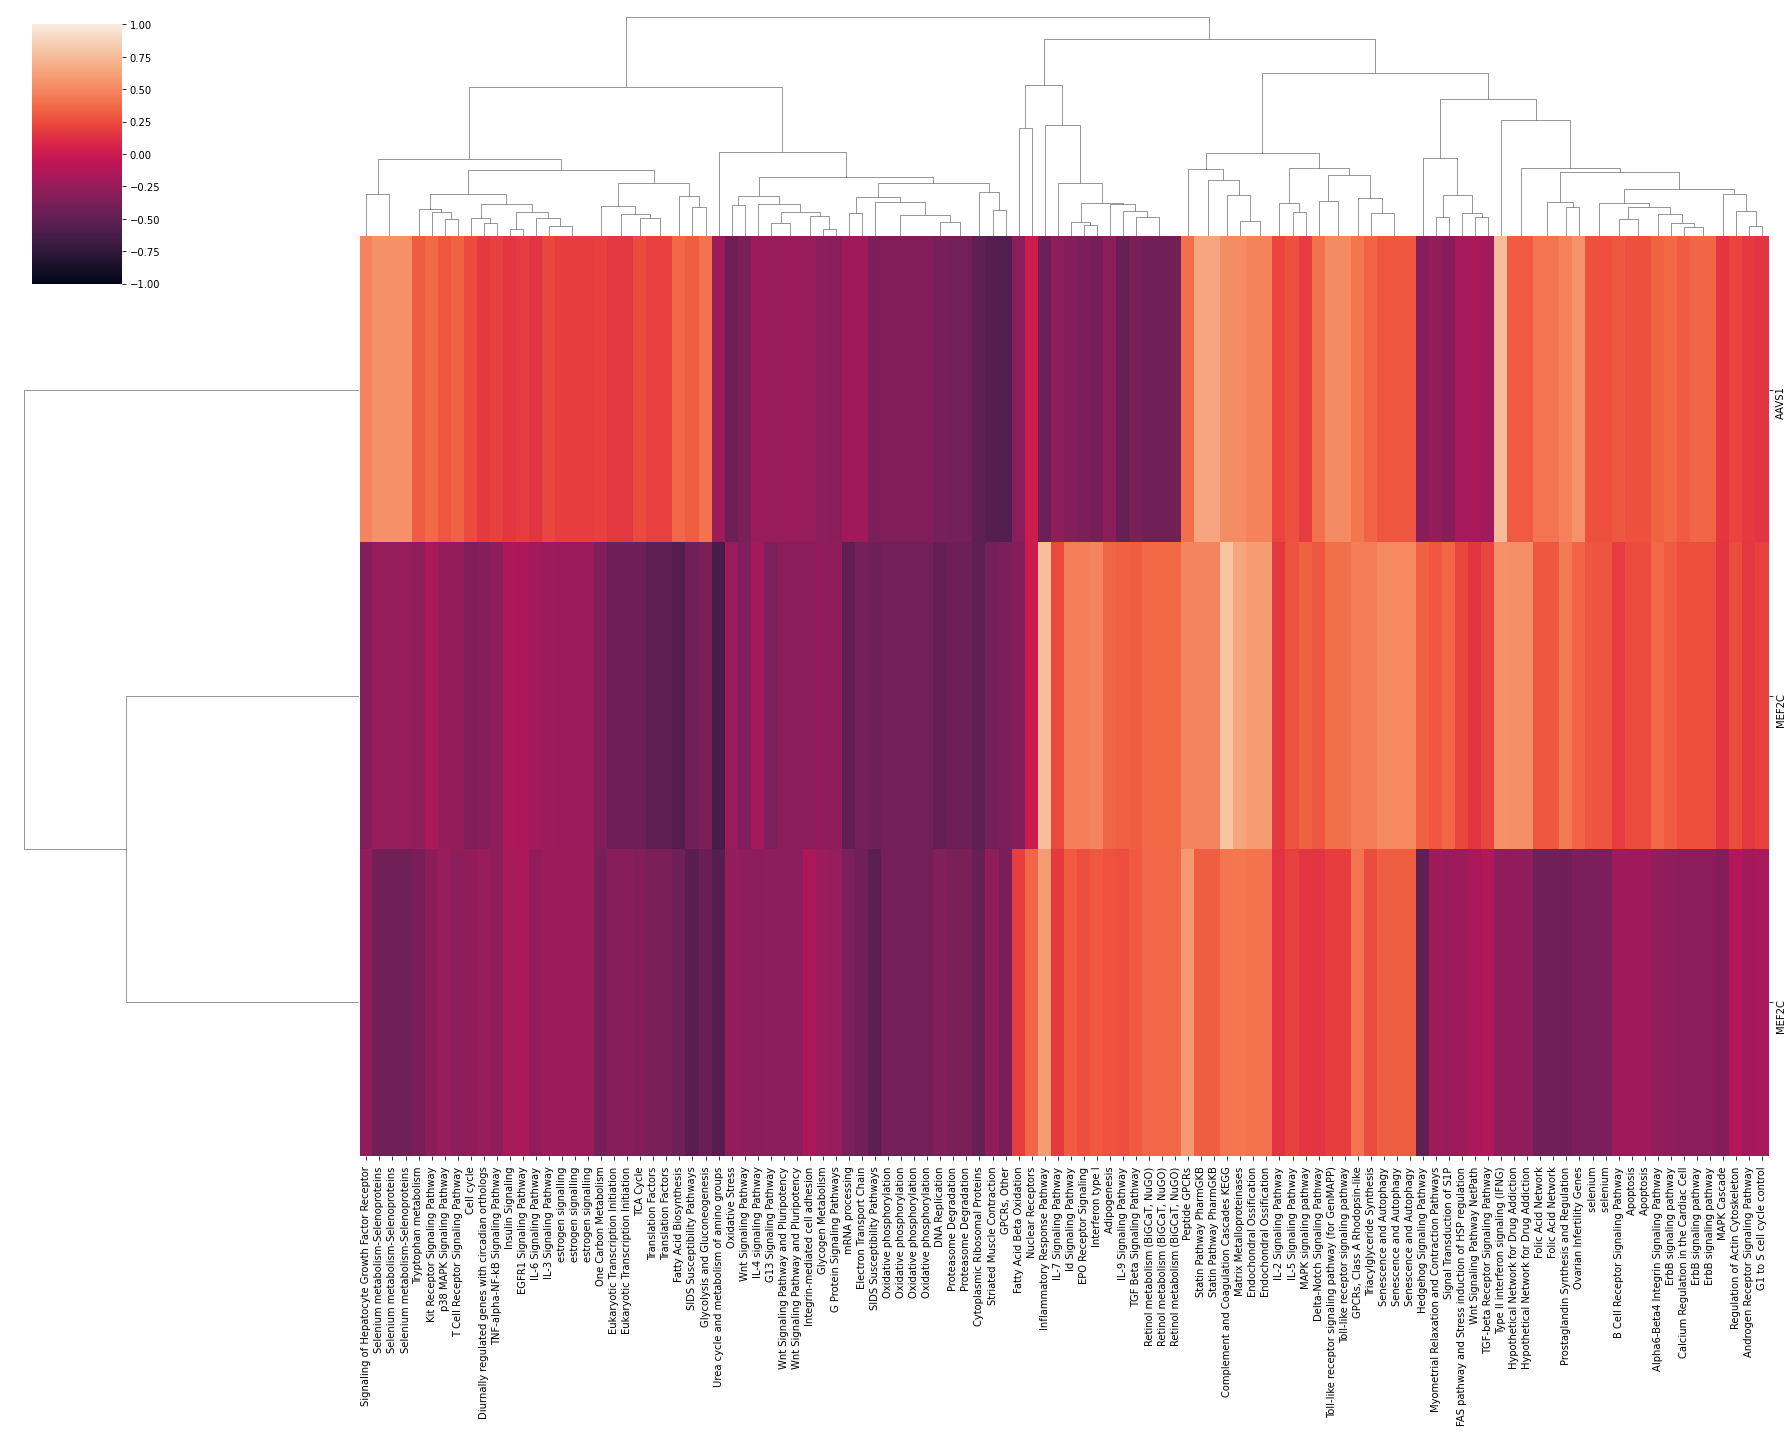

In [168]:
fig = sns.clustermap(figsize=(25,20), data=res,vmin=-1,vmax=1,xticklabels=res.columns, yticklabels=res.index)
fig.savefig("../results/"+project+"/"+version+"enriched_terms_scaled_gsea.pdf")

In [ ]:
res.to_csv('../results/'+project+'/'+version+'_wikipathway_gsea_matrix.csv')

In [ ]:
res = {}

In [ ]:
res.keys()

### Analysis on the entire set of pathways (biopathways)

In [ ]:
for i, val in enumerate(experiments):
    print(val)
    totest = data[[v for v in data.columns[:-1] if val+'-' in v or 'AAVS1' in v]]
    cls = ['Condition' if val+'-' in v else 'DMSO' for v in totest.columns]
    if abs(scaling[val.split('_')[1]][0]) > 3*scaling[val.split('_')[1]][1]:
        print("rescaling this one")
        cols = [i for i in totest.columns if val+'-' in i]
        totest[cols] = totest[cols]*(2**scaling[val.split('_')[1]][0])
    elif val in res:
        continue
    res[val] = gseapy.gsea(data=totest, gene_sets='GO_Biological_Process_2015', 
                cls= cls, no_plot=False, processes=8)
    res[val].res2d['Term'] = [i for i in res[val].res2d.index]
    plt.figure(i)
    a = sns.barplot(data=res[val].res2d.iloc[:25], x="es", y="Term",
                hue_order="geneset_size")
    a.set_title(val)
    a.figure.savefig('../results/'+ project+ '/plots/'+version + '_gobioproc2015_mainTerms_'+val+'.pdf')

In [ ]:
with open('../results/'+project+'/'+version+'_GO_Biological_Process_2015_RNPv2', 'wb') as f:
    pickle.dump(res,f)

In [ ]:
with open('../results/'+project+'/'+version+'_GO_Biological_Process_2015_RNPv2', 'wb') as f:
    res = pickle.load(f)

In [ ]:
for i, v in res.items():
    res[i].res2d['Term'] = [i.split('(GO')[0] for i in v.res2d['Term']]

creating matrices

In [ ]:
a = set()
for k, val in res.items():
    a.update(set(val.res2d.Term))
a = {i:[0]*len(res) for i in a}
for n,(k, val) in enumerate(res.items()):
    for i,v in val.res2d.iterrows():
        a[v.Term][n] = v.es
res = pd.DataFrame(a, index=res.keys())

In [ ]:
fig = sns.clustermap(figsize=(25,20), data=res,vmin=-1,vmax=1, yticklabels=res.index ,cmap=plt.cm.RdYlBu)
fig.savefig("../results/"+project+"/"+version+"enriched_terms_scaled_gsea_bioproc2015.pdf")

In [ ]:
model = DBSCAN(eps=0.5, min_samples=3, metric='euclidean')
labels = model.fit_predict(res)

In [ ]:
sort = labels.argsort()

### Correlation matrix across experiment on at the gene set level

In [ ]:
a = sns.clustermap(-res.T.corr(),cmap=plt.cm.RdYlBu,vmin=-1,vmax=1)
a.savefig("../results/"+project+"/plots/"+version+"_clustermap_over_bioproc2015_geneset.pdf")

In [ ]:
a = h.plotCorrelationMatrix(res.values[sort], res.index[sort].tolist(), interactive=True, title="correlation matrix over bioproc2015 gene sets", folder="../results/"+project+"/plots/"+version+"_")#,colors=[labels[i] for i in sort]) 

### similarity distance plot over the genesets 

In [ ]:
red = PCA(2).fit_transform(res)
h.scatter(red, labels=res.index, radi=1, colors=labels, title="PCA distance in geneset space", showlabels=True,folder="../results/"+project+"/plots/"+version+"_")

In [ ]:
red = TSNE(2,2).fit_transform(res)
h.scatter(red, labels=res.index, radi=9, colors=labels, title="TSNE distance in geneset space",showlabels=True,folder="../results/"+project+"/plots/"+version+"_")

In [ ]:
res.to_csv('../results/'+project+'/'+version+'_biopathway_gsea.csv')

In [ ]:
res = pd.read_csv('../results/'+project+'/'+version+'_biopathway_gsea.csv',index_col=0)

## Getting the correlation at the transcriptome level

In [ ]:
data = pd.DataFrame(index=results['RNP_SP1'].index.tolist())
for i, v in results.items():
    data[i]=v.log2FoldChange

In [ ]:
model = AgglomerativeClustering(n_clusters=8,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(data.values.T)
ii = itertools.count(data.values.shape[1])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
sort = labels.argsort()

In [ ]:
model = DBSCAN(eps=0.5, min_samples=3, metric='euclidean')
labels = model.fit_predict(data.values)

In [ ]:
a = sns.clustermap(data.corr())
a.savefig("../results/"+project+"/plots/"+version+"_clustermap_correlation_transcriptome.pdf")

In [ ]:
a = h.plotCorrelationMatrix(data.values.T[sort], data.columns[sort].tolist(), interactive=True, title="transcriptome correlation",folder= "../results/"+project+"/plots/"+version+"_")#,colors=[labels[i] for i in sort]) 

In [ ]:
## Filtered version (set to 0 genes with low p_value)

In [ ]:
data = pd.DataFrame(index=results['RNP_SP1'].index.tolist())
for i, v in results.items():
    v.loc[v[v.pvalue>0.01].index,"log2FoldChange"]==0
    data[i]=v.log2FoldChange

In [ ]:
a = h.plotCorrelationMatrix(data.values.T[sort], data.columns[sort].tolist(), interactive=True, title="transcriptome correlation matrix over high pvalue genes",folder="../results/"+project+"/plots/"+version+"_")

In [ ]:
mostvar = data[(~data.index.str.contains('ERCC-')) & (data.var(1)>4)]

In [ ]:
a = sns.clustermap(-mostvar.corr(), cmap=plt.cm.RdYlBu, vmin=-1, vmax=1)
a.savefig("../results/"+project+"/plots/"+version+"_clustermap_mostvariable_genes.pdf")

### Doing it at the CRC members' expression only

In [ ]:
results_ctf = data.loc[set(['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'GFI1',
 'LMO2',
 'CEBPa',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ZMYND8']) & set(data.index)].T
model = AgglomerativeClustering(n_clusters=7,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(results_ctf)
ii = itertools.count(results_ctf.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
sort = labels.argsort()
h.plotCorrelationMatrix(results_ctf.values[sort], title="correlation matrix over similarity over CRC members aggregated with agglomerative clustering", folder="../results/"+project+'/plots/'+version+'_',names=results_ctf.index[sort].tolist(),interactive=True)

In [ ]:
a = sns.clustermap(results_ctf.corr())
a.set_title("clustermap of correlation matrix over similarity over CRC members")
a.figure.savefig('../results/'+project+'/plots/'+version+"_clustermap_correlation_CRConly.pdf")

In [ ]:
a.fig.savefig('../results/'+project+'/plots/'+version+"_pairplot_deseq_crconly.pdf")

In [ ]:
a = sns.pairplot(results_ctf.T)
a.fig.suptitle("pairplot of differential expression of CRC members under RNP of these members", y=1.08)
